In [1]:
import os
import sys

os.chdir('..')
sys.path.append('src')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.feature_selection import chi2, mutual_info_regression, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from utilsPlots import na_plot, plot_density_cat, plot_bars_target

In [3]:
random_state = 42
random.seed(42)
np.random.seed(42)

## Objective

Kaggle competition where the goal is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

## Exploratory data analysis

Data contained 8,693 samples and 14 features. `Transported` feature was considered as target.

There were 219 duplicated `Names` entries, although no `PassengerId` values were duplicated. Therefore, the dataset was assumed to be free of actual duplicates.

Missing values were found in all features except `Transported` and `PassengerId` (@fig-na). The percentages of missing values was around 2.0-2.5% and showed a random distribution (@fig-na-dist). The percentage of samples without missing values was 76%.


In [4]:
# load data
df_train = pd.read_csv('data/train.csv')

In [5]:
# number samples and features
print(f'Number of samples {df_train.shape[0]}')
print(f'Number of features {df_train.shape[1]}')

Number of samples 8693
Number of features 14


In [6]:
# view data
df_train.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [7]:
# any duplicated sample?
for feature in ['PassengerId', 'Name']:
    dupl = sum(df_train[feature].duplicated())
    print(f'Number of duplicated {feature}: {dupl}')

Number of duplicated PassengerId: 0
Number of duplicated Name: 219


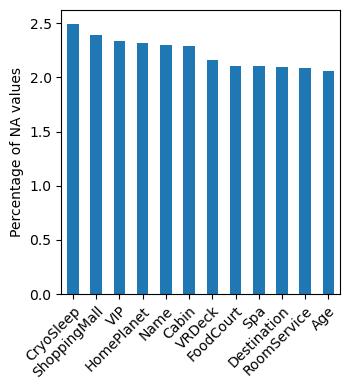

In [8]:
#| output: True
#| label: fig-na
#| fig-cap: "Percentage of missing values by feature (showing features with >30% NA values)"
na_plot(df_train)

In [9]:
print(df_train.isnull().sum().sort_values(ascending=False))

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
Spa             183
FoodCourt       183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


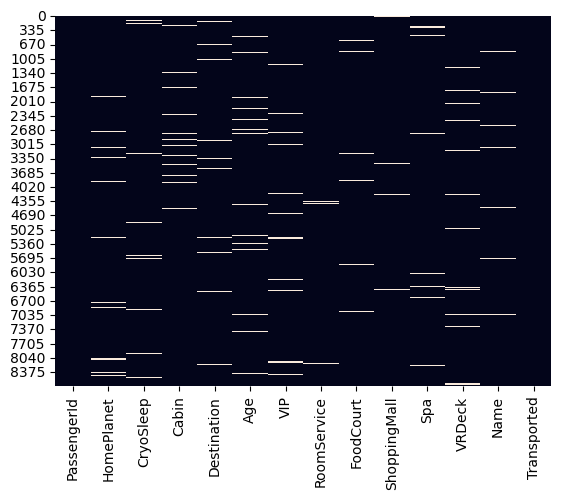

In [10]:
#| output: True
#| label: fig-na-dist
#| fig-cap: "Distribution of missing values by feature"
sns.heatmap(df_train.isna(), cbar=False)
plt.show()

In [11]:
# distribution of NA values in sample
df = df_train.drop(['PassengerId','Transported'], axis = 1)
na_perc = df.isna().sum(axis = 1)/len(df.columns)
#print('\nDistribution of NA in samples')
#print(na_perc.describe())
print(f'Percentage of samples without missing values: {sum(na_perc == 0)/df_train.shape[0]*100:.1f}%')

Percentage of samples without missing values: 76.0%


In [12]:
#df_train, df_test = train_test_split(df_train, test_size = 0.3, shuffle = True, random_state = random_state)

### Target feature.

The `Transported` feature had the following distribution: 

- True: 4378 samples.
- False: 4315 samples.

This indicates a well-balanced distribution between the two classes.

In [13]:
# distribution of target values
print(f'Number True values: {df_train["Transported"].sum()}')
print(f'Number False values: {(~df_train["Transported"]).sum()}')

Number True values: 4378
Number False values: 4315


### Features for prediction.

Some features had to be processed in a initial transformation step. The `Cabin` feature was splitted into three features: `Deck`, `Num` and `Side`, and the `Name` feature was splitted into `FirstName` and `Surname`.


In [14]:
# TODO Quantitative features distribution
# TODO Qualitative features distribution
# TODO New features
# TODO Relationships

In [15]:
# process Cabin feature (takes the form deck/num/side, where side can be either P for Port or S for Starboard)
df_train[['Deck','Num','Side']] = df_train['Cabin'].str.split('/', expand = True)

In [16]:
df_train[['FirstName','Surname']] = df_train['Name'].str.split(' ', expand = True)
print(f'Number of different surnames: {df_train["Surname"].unique().shape[0]}')

Number of different surnames: 2218


#### Continuous quantitative

First, `Age` and `Num` features were analyzed and distributions are shown in @fig-age-num. The `Age` feature exhibits a bimodal distribution, with a small peak for very young children and a larger, more prominent peak for individuals in their early twenties. Plot suggests that younger passengers might have a lower probability of being transported. The `Num` feature's distribution is right-skewed, indicating that most samples have low values for this feature. There appears to be an inverse relationship with the target: lower values for `Num` seem to correlate with a higher probability of being transported, while higher values correlate with a lower probability.

In [17]:
# distribution feature 'Num' 
print("Num from 'Cabin' feature distribution")
print(df_train[~df_train['Num'].isna()]['Num'].astype(int).describe())
# convert to int keeping NAs
df_train['Num'] = df_train['Num'].fillna(0)
df_train['Num'] = df_train['Num'].astype(int)
df_train.loc[df_train['Num'] == 0, 'Num'] = np.nan

Num from 'Cabin' feature distribution
count    8494.000000
mean      600.367671
std       511.867226
min         0.000000
25%       167.250000
50%       427.000000
75%       999.000000
max      1894.000000
Name: Num, dtype: float64


In [18]:
print(df_train['Age'].describe())

count    8514.000000
mean       28.827930
std        14.489021
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64


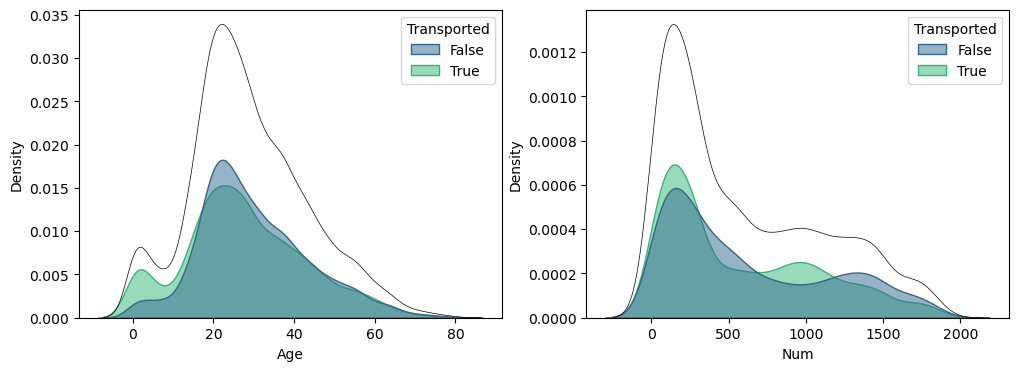

In [19]:
#| output: True
#| label: fig-age-num
#| fig-cap: "Distribution of values for Age and Num features"
plot_density_cat(df_train, ['Age', 'Num'], 'Transported', 1, 2)


Additionally, we analyzed the expense-related features. Passengers with `CryoSleep` set to `True` were excluded from this analysis, as they incurred no expenses. For improved visualization, these features were transformed using a logarithmic scale (@fig-exp)

After the transformation, all expense features exhibited a bimodal distribution, with a primary peak at the lower end and a secondary peak around a log-scale value of three. The `TotalExpenses` feature was the exception; while it also showed a bimodal pattern, its more prominent peak was the one centered at the higher value.

Passengers who spent more on `RoomService`, `Spa`, and `VRDeck` had a lower probability of being transported. This suggests a negative correlation between spending on these luxury services and the transportation outcome.


In [20]:
# visualize 'RoomService', 'FoodCourt', 'ShoppingMail', 'Spa' and 'VRDeck' and new feature 'TotalExpenses'
expense_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalExpenses']
# calculate TotalExpenses features
df_train['TotalExpenses'] = df_train[expense_features[:-1]].sum(axis=1)
# remove samples with CryoSleep True (expenses equal to zero)
df = df_train[df_train['CryoSleep'] == False][expense_features + ['Transported']]
print(df.describe())

        RoomService     FoodCourt  ShoppingMall           Spa        VRDeck  \
count   5328.000000   5329.000000   5335.000000   5326.000000   5320.000000   
mean     350.146772    713.004316    270.586504    486.092940    475.716165   
std      803.080320   1970.547985    741.756155   1396.233751   1404.174304   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        3.000000      5.000000      2.000000      7.000000      4.000000   
75%      390.250000    537.000000    242.000000    354.750000    356.000000   
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000   

       TotalExpenses  
count    5439.000000  
mean     2248.299687  
std      3245.061489  
min         0.000000  
25%       746.000000  
50%      1019.000000  
75%      2416.000000  
max     35987.000000  


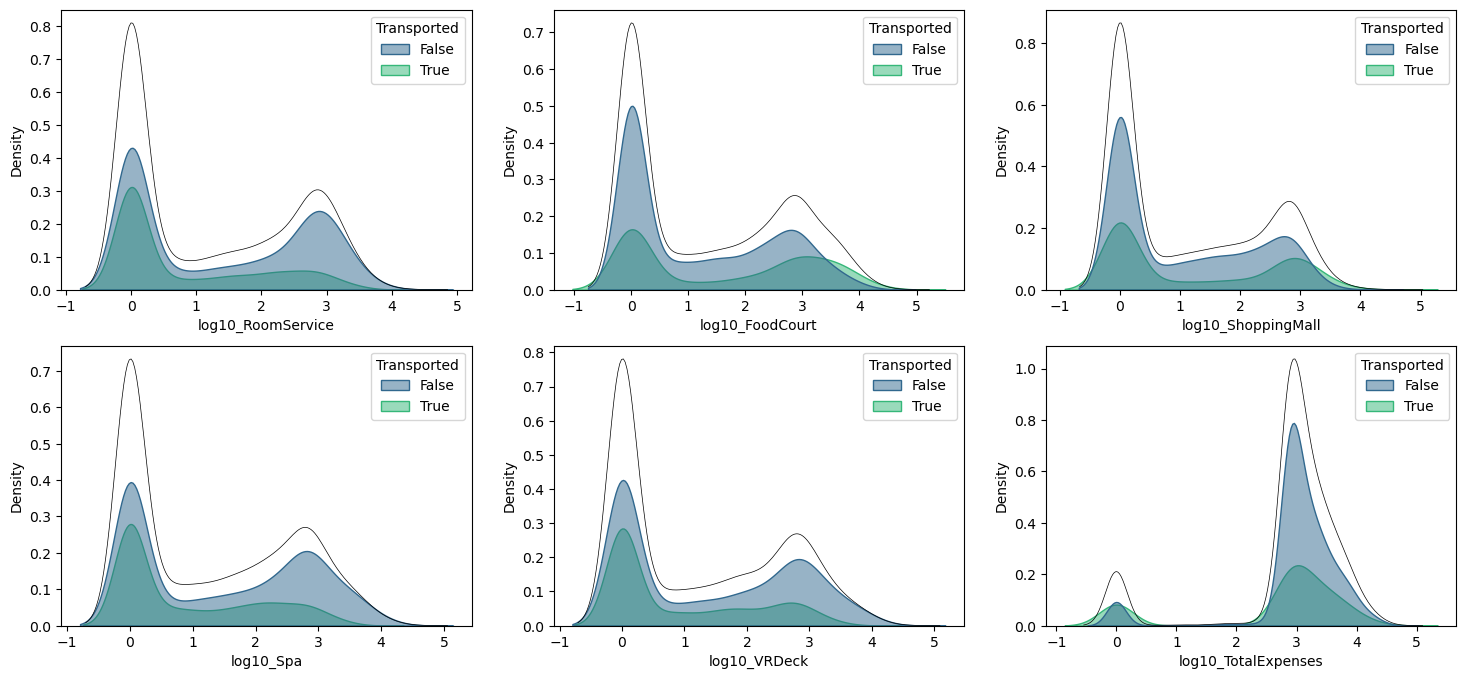

In [21]:
#| output: True
#| label: fig-exp
#| fig-cap: "Distribution of values for features related to expenses"
# visualize 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa' and 'VRDeck' and new feature 'TotalExpenses' applying log10
expense_features_log10 = list(map(lambda x: 'log10_' + x, expense_features))
# apply log10
df_train[expense_features_log10] = df_train[expense_features].apply(lambda x: np.log10(x + 1))
# remove samples with CryoSleep True (expenses equal to zero)
df = df_train[df_train['CryoSleep'] == False][expense_features_log10 + ['Transported']]
plot_density_cat(df, expense_features_log10, 'Transported', 2, 3)

#### Categorical 

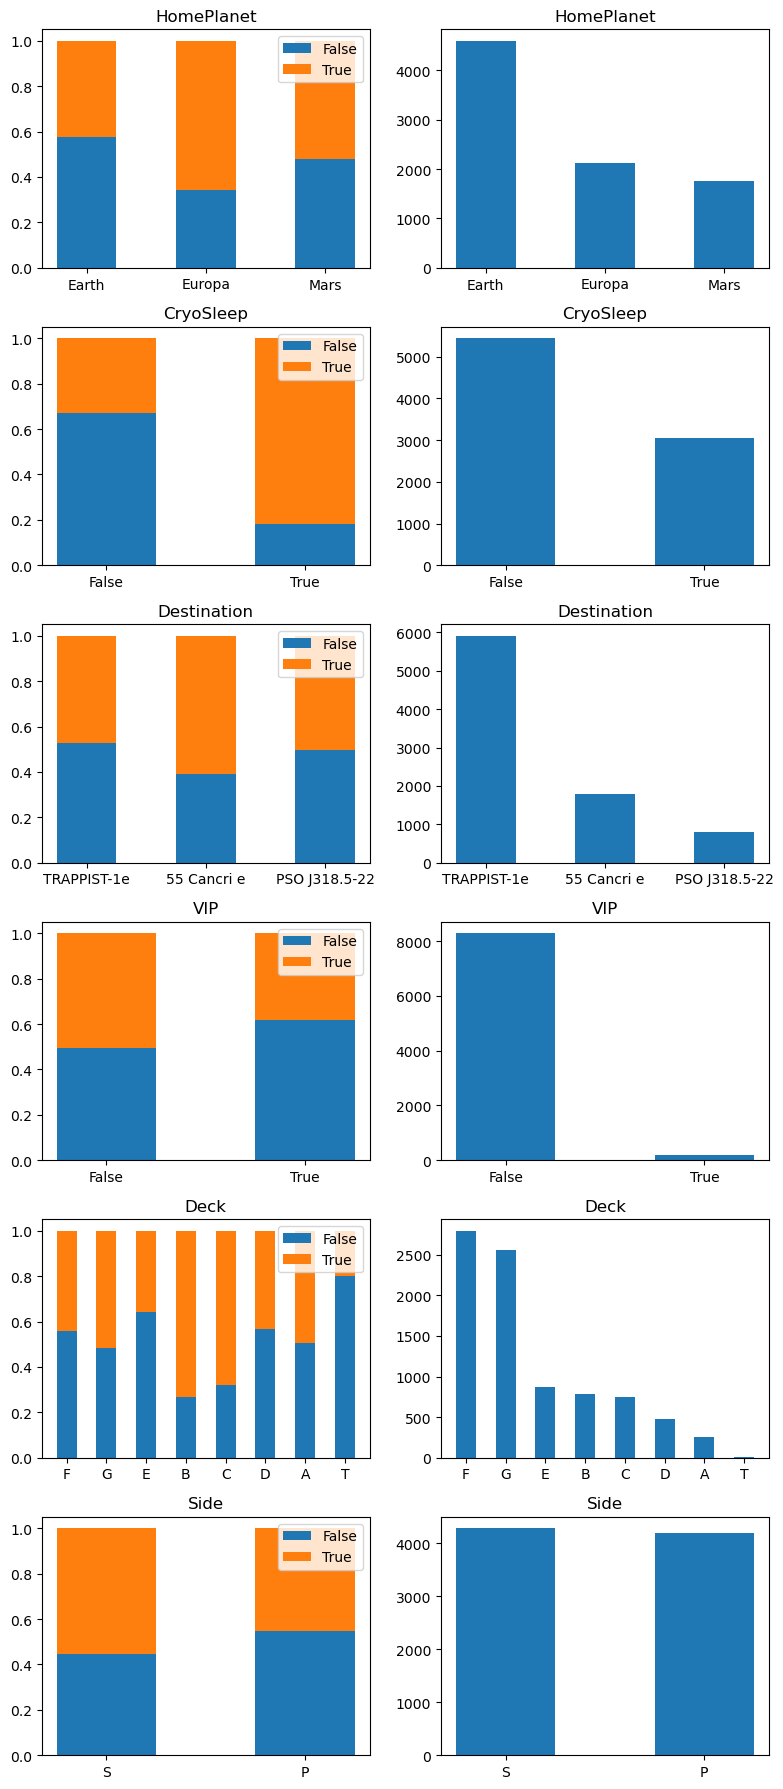

In [24]:
#| output: True
#| label: fig-cat
#| fig-cap: "Distribution of categorical features"
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
plot_bars_target(df_train, cat_features , 'Transported', sort = True)

### New features

In [18]:
# New feature Age < 12 True/False
df_train['Age12'] = df_train['Age'].apply(lambda x: 'True' if x < 12 else 'False')
# New features Deck C,E,F/Others and Deck B,C,E,F/Others
df_train['Deck_OnlyB'] = df_train['Deck'].apply(lambda x: 'True' if x == 'B' else 'False')
df_train['Deck_CEF'] = df_train['Deck'].apply(lambda x: 'True' if x in ('C', 'E', 'F') else 'False')
df_train['Deck_BCEF'] = df_train['Deck'].apply(lambda x: 'True' if x in ('B', 'C', 'E', 'F') else 'False')
# New features log10_RoomService < 1 True/False
# Same for log10_FoodCourt, log10_ShoppingMall, log10_Spa, log10_VRDeck and log10_TotalExpenses
features = ['log10_RoomService', 'log10_FoodCourt', 'log10_ShoppingMall', 'log10_Spa', 'log10_VRDeck', 'log10_TotalExpenses']
for feature in features:
    new_feature = f'Expenses{feature}1'
    df_train[new_feature] = df_train[feature].apply(lambda x: 'True' if x < 1 else 'False')
new_features = ['Age12', 'Deck_OnlyB', 'Deck_CEF', 'Deck_BCEF'] + list(map(lambda x: f'Expenses{x}1', features))


### Correlation between explanatory features

#### Numerical features (Pearson correlation coeficient)

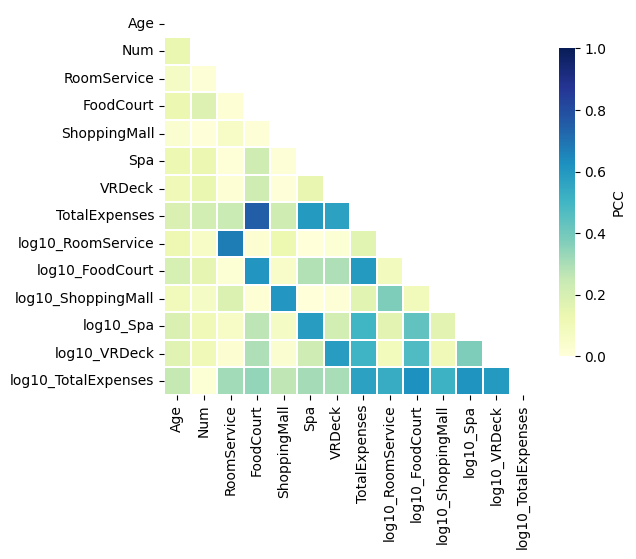

In [19]:
# correlation between quantitative features
selected_features = ['Age', 'Num'] + expense_features  + expense_features_log10
df = df_train[selected_features]
df = df.dropna()

# compute the correlation matrix
corr = np.abs(df.corr())

# plot heatmap
heatmap_triangle(corr, 'PCC')

#### Categorical features (Cramer's V test)

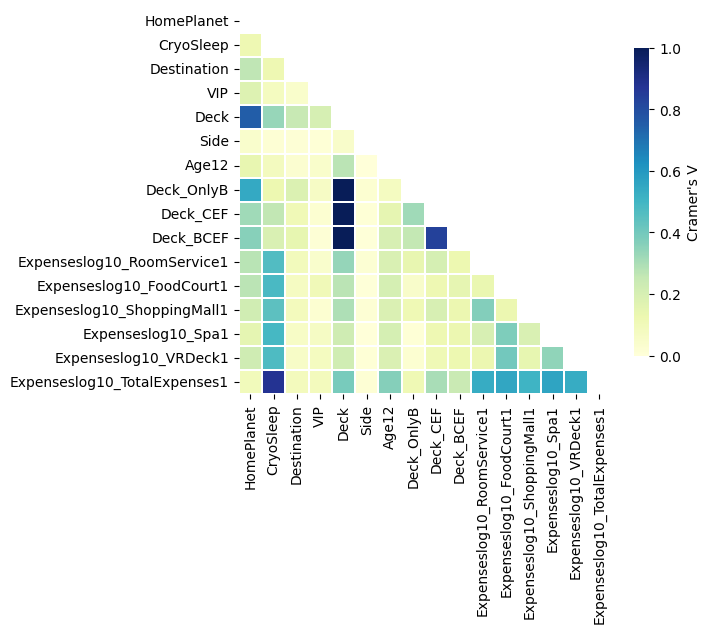

In [20]:
# relationship between categorical features (Cramer's V test)
categ_features= ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side'] + new_features

scores = []
for feature1 in categ_features:
    score_feature = []
    for feature2 in categ_features:
        score_feature.append(cramers_v(df_train[feature1], df_train[feature2]))
    scores.append(score_feature)

cramer = pd.DataFrame(scores, columns = categ_features, index = categ_features)

heatmap_triangle(cramer, "Cramer's V")

#### Categorical vs Numeric features (Eta squared)

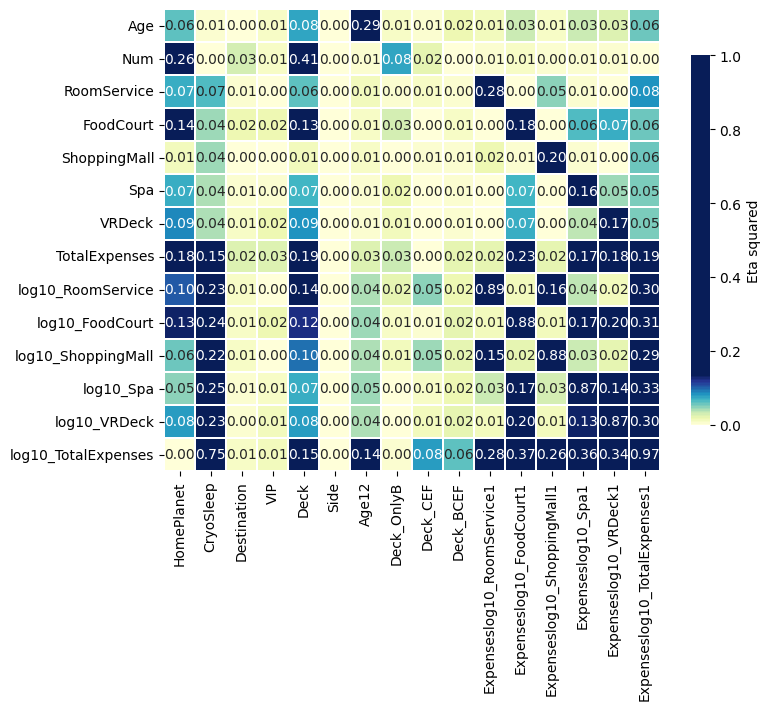

In [21]:
# relationship between quantitative vs qualitative features (Eta squared)
quant_features = ['Age', 'Num'] + expense_features + expense_features_log10

df = df_train[categ_features + quant_features]
df = df.dropna()

scores = []
for qf in quant_features:
    score_feature = []
    for cf in categ_features:
        formula = f'{qf} ~ {cf}'
        score_feature.append(eta_squared(df, formula))
    scores.append(score_feature)

eta2 = pd.DataFrame(scores, columns = categ_features, index = quant_features)

heatmap_threshold(eta2, 0.14, 'Eta squared')

### Correlation between target and explanatory features

#### Numerical features

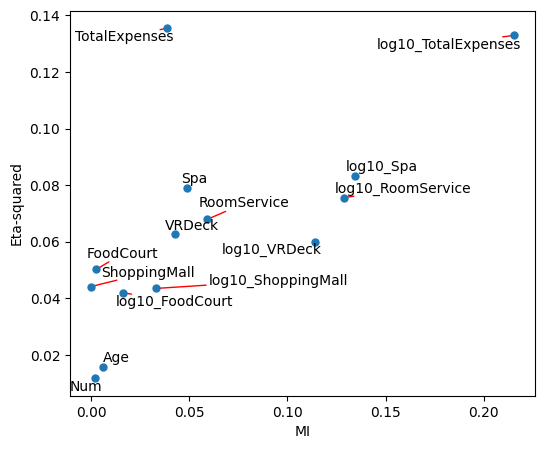

In [22]:
# relationship between quantitative features vs target (eta-squared/MI)

df = df_train[quant_features + ['Transported']]
df = df.dropna()

X = df[quant_features]
y = df['Transported']
mi = mutual_info_classif(X, y).tolist()
# f = f_classif(X, y)[0].tolist()
eta2 = []
for qf in quant_features:
    formula = f'{qf} ~ Transported'
    eta2.append(eta_squared(df, formula))

feature_stats = {'feature': quant_features, 'stat': eta2, 'mi': mi}

plot_stat_vs_mi_num(feature_stats, 'Eta-squared')

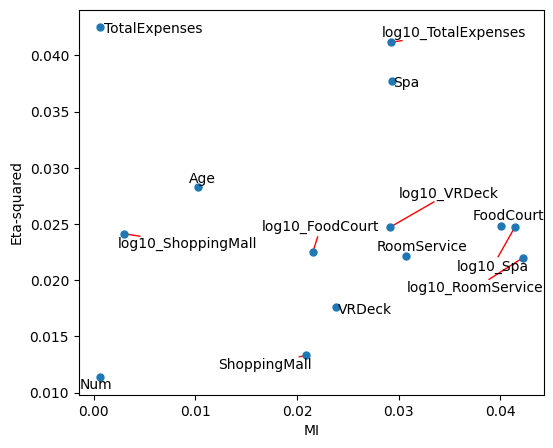

In [23]:
# relationship between quantitative features vs target (eta-squared/MI)
# remove CryoSleep True 

df = df_train[quant_features + ['Transported','CryoSleep']]
df = df.dropna()
df = df[df['CryoSleep'] != True]

#df['Num'] = df['Num'].astype(int)

X = df[quant_features]
y = df['Transported']
mi = mutual_info_classif(X, y).tolist()
# f = f_classif(X, y)[0].tolist()
eta2 = []
for qf in quant_features:
    formula = f'{qf} ~ Transported'
    eta2.append(eta_squared(df, formula))

feature_stats = {'feature': quant_features, 'stat': eta2, 'mi': mi}

plot_stat_vs_mi_num(feature_stats, 'Eta-squared')

#### Categorical features

16 [0.58105598 0.1227859 ]
17 [ 0.9943579  -0.63356997]
9 [-0.72676675  0.83127649]
19 [-0.41378709 -0.34610827]


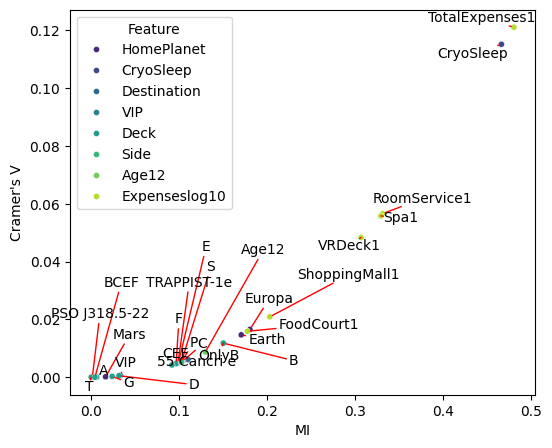

15 [0.93019099 0.80638747]
16 [-0.20126821  0.18698315]
8 [-0.95684974  0.3442775 ]
18 [0.4905491 0.2309276]


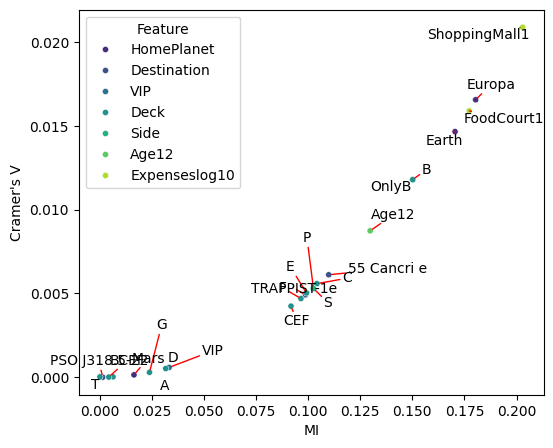

In [24]:
# relationship between categorical features vs target (Cramer's V test/MI)
# categ_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
TF_features = ['VIP', 'CryoSleep'] + new_features
drop_features = list(map(lambda x: f'{x}_False', TF_features))
df = df_train[categ_features + ['Transported']].dropna()
# one-hot encode (required for scikit-learn)
#X_encoded = pd.get_dummies(df[categ_features]).drop(['VIP_False', 'CryoSleep_False'], axis=1)
X_encoded = pd.get_dummies(df[categ_features])
X_encoded = pd.get_dummies(df[categ_features]).drop(drop_features, axis=1)
y = df['Transported']

# calculate MI scores for feature selection
mi = mutual_info_classif(X_encoded, y, discrete_features=True) 

# calculate Cramer's V scores for feature selection
cramer = []
for cf in X_encoded.columns:
    cramer.append(cramers_v(X_encoded[cf], df['Transported']))

# build dataframe for plot
features_levels = list(map(lambda x: x.split('_'),X_encoded.columns))
features = list(map(lambda x: x[0], features_levels))
levels = list(map(lambda x: x[1], features_levels))
feature_stats = {'feature': features, 'level': levels, 'stat': cramer, 'mi': mi}

df = pd.DataFrame(feature_stats)
df['level'] = df.apply(lambda row: row['feature'] if row['level'] == 'True' else row['level'], axis=1)

plot_stat_vs_mi_cat(df, "Cramer's V")

df_filt = df[~df['level'].isin(['CryoSleep','TotalExpenses1','RoomService1','Spa1','VRDeck1'])].reset_index(drop=True)
plot_stat_vs_mi_cat(df_filt, "Cramer's V")

### Relationship between expenses and 'CryoSleep' and 'Age' features

In [25]:
print("People with 'CryoSleep' equal to True have no expenses")
print(df_train[df_train['CryoSleep'] == True][['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum())
print("\nPeople with 'Age' less than 13 have no expenses")
print(df_train[df_train['Age'] < 13][['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum())

People with 'CryoSleep' equal to True have no expenses
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64

People with 'Age' less than 13 have no expenses
RoomService     0.0
FoodCourt       0.0
ShoppingMall    0.0
Spa             0.0
VRDeck          0.0
dtype: float64


### Conclusions

Based on the results obtained for the correlations between the explanatory variables and the correlations between the explanatory variables and the target variable, the following variable usage is planned:

- log10TotalExpenses, CryoSleep, and log10TotalExpenses1 are variables with strong potential to explain the target variable. However, they should not be used together because they exhibit high multicollinearity.

- HomePlanet shows a strong association with the target variable. Additionally, it has no significant correlation with the aforementioned variables, making it a good candidate to combine with them.

- Age12, unlike Age, displays a high association with the target variable. It is strongly correlated with log10TotalExpenses and log10TotalExpenses1, so the best combination would be with CryoSleep.

- The variable Deck is highly associated with the target variable, particularly Deck B. Levels C, E, and F also show strong (though slightly weaker) associations. However, Deck is highly correlated with HomePlanet and log10TotalExpenses. Using only Deck B eliminates these correlations, allowing it to be combined with the other variables.

- The variables Destination and Side exhibit some association with the target variable and no significant correlations with the other explanatory variables.

Based on the observed data patterns, variables 'CryoSleep' and 'Age' can be confidently used to impute the expense-related variables. This imputation reduce the percentage of non-available values for the expense-related varaibles.